# Individual Parcellation Example
This jupyter notebook is to demonstrate a minimal example for generating individual cerebellar parcellations using a new individual localization dataset. Usually, the individual data are collected within a relatively short period (e.g. 10 mins). If we generate individual parcellations based on those data directly using some traditional methods, the results are poor and very noisy. In the ``HierarchBayesParcel`` framework, the individual parcellations are generated using an optimal integration of a common group prior and the individual localizing data. The main idea is to regularize the noisy individual parcellation estimate towards the group map (the prior) just by the right amount.  

The pipeline has two main steps: 
* Train a new emission model for the particular individual localization data. This step can be skipped if you already have a pretrained model for your specific task or resting-state dataset and atlas. 
* Derive the individual parcellations based on the trained emission model and the group prior.

For data import and export we are using the `Functional_Fusion <https://github.com/DiedrichsenLab/Functional_Fusion>`_ Framework, which needs to be installed in addition to the `HierarchBayesParcel` package.

In [1]:
import numpy as np
import torch as pt
import nibabel as nb
import nitools as nt
import pandas as pd
import matplotlib.pyplot as plt
import Functional_Fusion.atlas_map as am
import Functional_Fusion.dataset as ds
import HierarchBayesParcel.arrangements as ar
import HierarchBayesParcel.emissions as em
import HierarchBayesParcel.full_model as fm
import HierarchBayesParcel.util as ut
import SUITPy as suit


## Step 1: Define the the space in which to generate the individual parcellations
This step defines the atlas space (e.g. fs32k, SUIT, MNISymC3, etc) - an atlas in Functional_Fusion defines a specific set of brainlocations (grayordinates) that are being sampled. Both the probabilistic atlas and the data need to be read into this space.

In [2]:
atlas, _ = am.get_atlas('MNISymC3')

## Step 2: Load the probabilistic group atlas
First, we sample the probabilistic group atlas U from a _probseg.nii file at the required brain location. The resultant matrix U has a shape (K by P), where K is the number of parcel and P is the number of brain locations (voxels).

In [3]:
# Sample the probabilistic atlas at the specific atlas grayordinates
atlas_fname = 'atl-NettekovenSym32_space-MNI152NLin2009cSymC_probseg.nii.gz'
U = atlas.read_data(atlas_fname)
U = U.T

## Step 3: Build an arrangement model
In the `HierarchBayesParcel` the probabilistic atlas is encoded in the `arrangement model`. Depending on whether you want an symmetric or asymmetric individual parcellations, you can choose a `ArrangeIndependent` or `ArrangeIndependentSymmetric` model. The utility function `build_arrangement_model` simply initializes the arrangement model, making sure that NaN and zero values in the `probseg.nii` files are handled correctly.  

In [4]:
# Build the arrangement model - the parameters are the log-probabilities of the atlas
ar_model = ar.build_arrangement_model(U, prior_type='prob', atlas=atlas)

/Users/jdiedrichsen/Python/HierarchBayesParcel/HierarchBayesParcel/arrangements.py:1867: UserWarning: The marginal probability has 4 voxels NaN value - replacing with flat distribution
  warnings.warn(f'The marginal probability has {nan_voxl} voxels '
/Users/jdiedrichsen/Python/HierarchBayesParcel/HierarchBayesParcel/arrangements.py:1874: UserWarning: The marginal probability has 5373 voxels zero values - adding small value to avoid -inf
  warnings.warn(f'The marginal probability has {zero_voxl} voxels'


## Step 4: Load individual localizing data
For model training, the data of all subjects needs to be arranged into a num_subj x N x P tensor, where N is the number of observations, and P is the number of brain locations (voxels). To estimate the concentration parameter efficiently, it is useful to have multiple measures of the same conditions. In this example, we have only two repetitions per condition. 

In [5]:
data_dir = 'data_mdtb'
# Read the participant tsv file to get the name of the available subjects
subj_info = pd.read_csv(f'{data_dir}/participants.tsv',sep='\t')
data = []
# Read the data for each subject
for i, s in enumerate(subj_info['participant_id']):
        file_name = f'{data_dir}/{s}_space-{atlas.name}_ses-s1_CondHalf.dscalar.nii'
        datafile = nb.load(file_name)
        data.append(datafile.get_fdata())
# make the numsubj x numcond x numvoxel tensor
data = np.stack(data)

The vector `cond_v` indicates the number of the condition, the vector `part_v` indicates the number of independent data partition (e.g. runs).  


In [6]:
info = pd.read_csv(f'{data_dir}/info-CondHalf.tsv',sep='\t')
cond_v = info['cond_num_uni'].values
part_v = info['half'].values

## Step 5: Fit the emission model to the data
For a new localization dataset, we need to fit the emission model to the data. In this step, we estimation the average functional profiles for each region ($V$) and the concentration parameter ($\kappa$) for the von Mises-Fisher distribution.
Of course, we want to keep the atlas the same, so the arrangement model will not be fit.



In [7]:
# K is the number of parcels
K = ar_model.K
# Make a design matrix
X= ut.indicator(cond_v)
# Build an emission model
em_model = em.MixVMF(K=K,P=atlas.P, X=X,part_vec=part_v)
# Build the full model: The emission models are passed as a list, as usually we have multiple data sets
M = fm.FullMultiModel(ar_model, [em_model])
# Attach the data to the model - this is done for speed
# The data is passed as a list with on element per data set
M.initialize([data])

# Now we can run the EM algorithm
M, ll, _, U_indiv = M.fit_em(iter=200, tol=0.01,
    fit_arrangement=False,fit_emission=True,first_evidence=False)


## Step 6: Get the individual parcellation for a new subject
The last step already returns the individual parcellation for all the subjects in the localizer dataset. However, if you ever want to use a trained emission model to generate individual parcellations for a new subject, you would simply attach the new data and then run a simple Estep. 

In [8]:
M.initialize([data])
U_indiv,_ = M.Estep()

## Step 7: Visualize the individual parcellations
In the last step, we project the individual parcellations back into Volume space. 
We then use the SUITPy toolbox to visualize these on the surface.

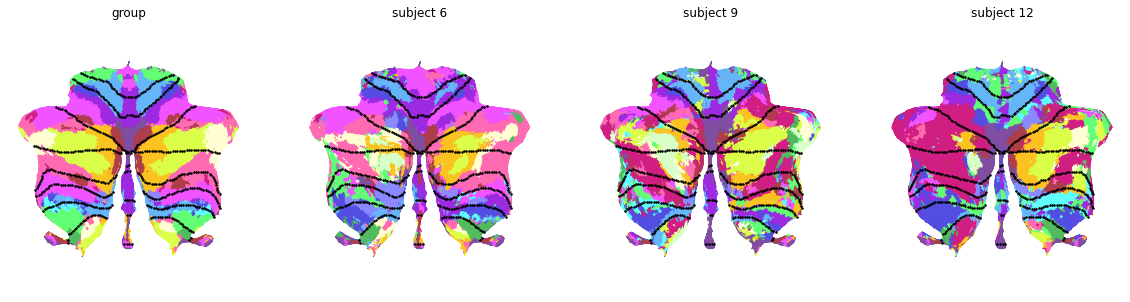

In [9]:

def plot_probseg(nifti,cmap):
    # Project the nifti image to the surface over the MNISymC space
    surf_data = suit.flatmap.vol_to_surf(nifti, stats='nanmean',space='MNISymC')
    label = np.argmax(surf_data, axis=1)+1

    suit.flatmap.plot(label,
        render='matplotlib',
        cmap=cmap,
        cscale=[0,31],
        label_names = names,
        new_figure=False,
        overlay_type='label',
        bordersize=3,
    )

# Load colormap and labels
lid,cmap,names = nt.read_lut('atl-NettekovenSym32.lut')

# Make a nifti image of the first subject
nifti = atlas.data_to_nifti(U)

# Make a figure
plt.figure(figsize=(20,5))

# plot the group probabilistic atlas
plt.subplot(1,4,1,title='group')
plot_probseg(nifti,cmap)

# plot 3 individual subjects
for i,s in enumerate([6,9,12]):
    plt.subplot(1,4,i+2,title=f'subject {s}')
    nifti = atlas.data_to_nifti(U_indiv[s].numpy())
    plot_probseg(nifti,cmap)

plt.savefig('../docs/source/_static/indiv_parcel.png')